In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Imports

In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import wave, os, glob
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks

In [ ]:
###On importe chaque .wav pour le transformer en dataframe puis en indiquant son origine via la variable training
zero_a = []
zero_a = pd.DataFrame(zero_a)
path = '\\Python\\Projet\\training\\training-a'
for filename in glob.glob(os.path.join(path, '*.wav')):
    fs, data = wavfile.read(filename)
    df = pd.DataFrame(data)
    df = df.transpose()
    zero_a = zero_a.append(df)
    del data, fs

ref = pd.read_csv('\\REFERENCE.csv',sep = ',')
#On merge selon l'index car l'ordre est le même
base = pd.merge(df, ref, left_index=True, right_index=True)

#Export de la base
base.to_csv('training-a.csv', index  = False)

In [3]:
dataset = pd.read_csv('training-a.csv')

In [4]:
labels = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
raw_data = dataset.drop(['label'],axis=1)

## Traitement

In [5]:
phases_list = ['S1','S2','systole','diastole']
features_list = ['t1','t2','t12','t21']
phases_peak = ["S1","S2"]
fea_peak = ["S1","S2"]

In [309]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)])-np.mean(signal) #on ignore les NaN et on recentre le signal
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        mask = E>local_max/4
        mask2 = np.abs(E-m)>s/2
        mask3 = E>np.mean(E)*2
        return E*mask
    
    def setStart(self,E):
        #on s'assure de bien commencer sur une phase S1 ou S2
        start = 0
        while E[start]==0:
            start += 1
        E = E [start:]
        return E, start
    
    def consec_count(self):
        e = self.setStart(self.envelogram())[0]
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.setStart(self.envelogram())[0] # l'envelogramme commencé sur un battement
        count_vec = self.consec_count() # le vecteur de comptage associé
        beat_mask = count_vec<=100
        systole_mask = count_vec>100
        segmentation = np.asarray([])
        mean_S1_length = 0
        S1_counter = 0
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            while stop<count_vec.shape[0] and beat_mask[stop]:
                stop+=1
            #if np.max(E[i:stop])-np.min(E[i:stop])>(np.max(E)-np.min(E))*0.7 and stop-i>100:
            if len(find_peaks(E[i:stop],distance=5)[0])>5 and stop-i>mean_S1_length*0.7:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                current_seq = {'beat':'S1','passive':'systole'}
                mean_S1_length = np.average([mean_S1_length,stop-i],weights=np.array([S1_counter,1])/(S1_counter+1))
                S1_counter += 1
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                current_seq = {'beat':'S2','passive':'diastole'}
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            i = stop
            
        return segmentation
    
    def checkSegmentation(self,segmentation):
        systole_length = np.sum(segmentation=='systole')
        diastole_length = np.sum(segmentation=='diastole')
        average_systole_length = systole_length/(systole_length+diastole_length)
        average_diastole_length = diastole_length/(systole_length+diastole_length)
        return (average_systole_length<average_diastole_length)
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)
        return res[res!=0]
    
    def extractFeatures(self):
        segmentation = self.segmentation()
        features = {}
        for phase,ft in zip(phases_list,features_list):
            time_features = self.timeLengths(segmentation,phase)
            features.update({ft:[np.mean(time_features),np.min(time_features),
                                 np.max(time_features),np.std(time_features)]})
        return features
    
    def peak_Features(self):
        #Fonction peak à recontruire pour coller à la segmentation
        segmentation = self.segmentation()
        peak_features = {}
        p_S1 = []
        p_S2 = []
        E,lag = self.setStart(self.envelogram())
        borne = []
        for i in range(len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == 'S1':
                peaks, _ = find_peaks(E[borne[i]:borne[i+1]],height=0,distance = borne[i+1])
                if len(peaks) != 0:
                    index = borne[i] + peaks[0]
                    p_S1.append(E[index])    
            if segmentation[borne[i]] == 'S2':
                peaks, _ = find_peaks(E[borne[i]:borne[i+1]],height=0,distance = borne[i+1])
                if len(peaks) != 0:
                    index = borne[i] + peaks[0]
                    p_S2.append(E[index])
        peak_features.update({"S1":[np.mean(p_S1),np.min(p_S1),np.max(p_S1),np.std(p_S1)]})
        peak_features.update({"S2":[np.mean(p_S2),np.min(p_S2),np.max(p_S2),np.std(p_S2)]})
        return peak_features  
            
    def mean_Features(self):
        ft = self.extractFeatures()
        mean_features = {}
        mean_features.update({"mean_12" : [max(ft['t12'][0], ft['t21'][0])]})
        return mean_features 

# Visualisation

In [310]:
time_length = 10000
sample = raw_data.loc[3][:time_length]

In [311]:
pcg = PCG(sample)
segmentation = pcg.segmentation()

Text(0,0.5,'amplitude normalisée')

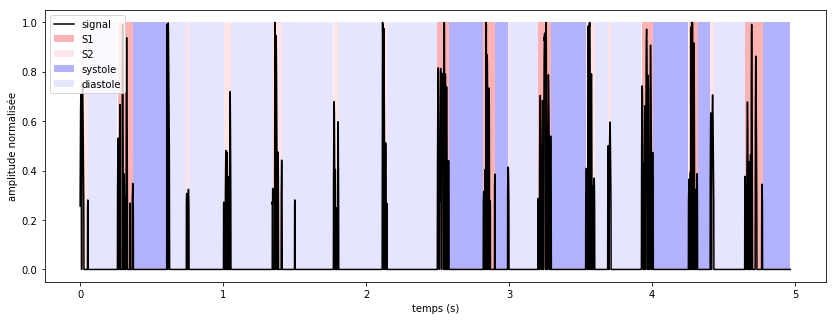

In [312]:
plt.figure(figsize=(14,5))
E,lag = pcg.setStart(pcg.envelogram())
l = time_length-lag
x = np.linspace(0,l/2000,l)
plt.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
plt.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
plt.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
plt.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')

plt.plot(x,E/np.max(E),'k',label='signal')
plt.legend()
plt.xlabel('temps (s)')
plt.ylabel('amplitude normalisée')

# Analyse des features

In [313]:
n_samples = raw_data.shape[0]

In [ ]:
t1,t2,t12,t21,ps1,ps2,m12 = [],[],[],[],[],[],[]
for i in range(n_samples):
    try:
        pcg = PCG(raw_data.loc[i])
        ft = pcg.extractFeatures()
        pft = pcg.peak_Features()
        mft = pcg.mean_Features()
        t1.append(ft['t1'][0])
        t2.append(ft['t2'][0])
        t12.append(ft['t12'][0])
        t21.append(ft['t21'][0])
        ps1.append(pft['S1'][0])
        ps2.append(pft['S2'][0])
        m12.append(mft['mean_12'][0])
    except: 
        pass

/Users/aymeric/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aymeric/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#Convertion en Df au cas où
X = np.column_stack((t1,t2,t12,t21,m12,ps1,ps2,good))
X_df = pd.DataFrame(X, columns=["t1","t2","t12","t21","mean12","S1","S2","Normal"])
X_df["Normal"] = X_df["Normal"].map({0 : "anormal", 1 : "normal"})

In [ ]:
#taleau descriptif
X_df.groupby(["Normal"]).describe().unstack()

In [ ]:
#Matrice de corrélation
sns.heatmap(X_df.corr())

In [ ]:
#Violin plot per variable
features_list = X_df.columns[:-1]
for i in features_list:
    fig = plt.figure()
    fig = plt.figure(figsize=(5,5))
    ax = sns.violinplot(x = [i]*len(X_df), y=X_df[i],hue=X_df["Normal"], palette="Set2", split = True)

In [126]:
good = labels[:n_samples]==1
bad = labels[:n_samples]==-1

In [ ]:
#Histogrammes par variable
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221)
#t = t
ax1.hist(t1[good],normed=True,color='b',label='normal',alpha=.5)
t = t1[bad]
ax1.hist(t1[bad],normed=True,color='r',label='anormal',alpha=.5)
ax1.set_title('t1')

ax2 = fig.add_subplot(222)
t = t2[good]
ax2.hist(t2[good],normed=True,color='b',label='normal',alpha=.5)
t = t2[bad]
ax2.hist(t2[bad],normed=True,color='r',label='anormal',alpha=.5)
ax2.set_title('t2')

ax3 = fig.add_subplot(223)
ax3.hist(t12[good],normed=True,color='b',label='normal',alpha=.5)
ax3.hist(t12[bad],normed=True,color='r',label='anormal',alpha=.5)
ax3.set_title('t12')

ax4 = fig.add_subplot(224)
ax4.hist(t21[good],normed=True,color='b',label='normal',alpha=.5)
ax4.hist(t21[bad],normed=True,color='r',label='anormal',alpha=.5)
ax4.set_title('t21')

# Classification

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

In [131]:
features = np.column_stack((t1,t2,t12,t21,ps1,ps2,m12))
features.shape

(407, 5)

In [132]:
labels_=np.concatenate((labels[:313],labels[315:]))
labels_.shape

(407,)

In [ ]:
#Logit
X_train, X_test, y_train, y_test = train_test_split(features, labels_, test_size=0.20)
logit = LogisticRegression()
result = logit.fit(X_train, y_train)
predictions = logit.predict(X_test)
print(accuracy_score(y_test, predictions))

In [ ]:
#RandomForest
X_train, X_test, y_train, y_test = train_test_split(features, labels_, test_size=0.20)
RF =  RandomForestClassifier(n_estimators=150, max_depth=5, random_state=0)
result = RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
print(accuracy_score(y_test, predictions))

In [ ]:
#SVM
X_train, X_test, y_train, y_test = train_test_split(features, labels_, test_size=0.20)
clf = svm.SVC()
result = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

In [135]:
rf = RandomForestClassifier()
svm = SVC()
print(cross_val_score(svm,features,labels_,cv=3))

[0.71323529 0.71323529 0.6962963 ]
